In [3]:
%load_ext autoreload

In [4]:
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import truncnorm, uniform
from statsmodels.tsa.api import VAR
import sys
from tqdm.auto import tqdm

sys.path.append('../../..')
from multiproc_VAR_p_grid_search import compute_VAR_p, predict_VAR_p
from nld_utils import simulate_baier_klein, simulate_double_pendulum, simulate_lorenz, simulate_rossler

## Set Up Time Variation

In [95]:
# def sample_from_disk(radius1, radius2, num_points):
#     # radius1 < radius2 <= 1
#     points = []
#     while len(points) < num_points:
#         x, y = np.random.uniform(-1, 1, size=(2, ))
#         r = np.sqrt(x**2 + y**2)
#         if r >= radius1 and r <= radius2:
#             points.append((x, y))
#             points.append((x, -y))
    
#     return np.array(points)

In [67]:
# TEST Sampling from a disk!
# pts = sample_from_disk(0.2, 0.5, 2000)

# plt.scatter(pts[:, 0], pts[:, 1])
# circle1 = plt.Circle((0, 0), 0.2, color='r', fill=False)
# circle2 = plt.Circle((0, 0), 0.5, color='r', fill=False)
# ax = plt.gca()
# ax.add_patch(circle1)
# ax.add_patch(circle2)
# ax.axis('equal')
# plt.show()

In [214]:
num_windows = 20
n = 10
dt = 0.001
# window_lengths = [2.8]*num_windows
window_lengths = np.random.normal(loc=5, scale=2, size=(num_windows))
# inner_disk_radii = np.linspace(0.2, 0.8, num_windows)
# outer_disk_radii = np.linspace(0.5, 1, num_windows)
max_cis = np.linspace(0.2, 0.99, num_windows)
A_mats = np.zeros((num_windows, n, n))
b = np.random.normal(size=(n,))
# b = np.zeros(n)
# bs = np.zeros((num_windows, n))

x0_mu = 0
x0_sigma = 0.1

noise_mu = 0
noise_sigma = 0.01

T = np.sum([int(w/dt) for w in window_lengths])
pts = np.zeros((T, n))

for i in range(num_windows):
#     eigs = [complex(pt[0], pt[1]) for pt in sample_from_disk(inner_disk_radii[i], outer_disk_radii[i], n)]
#     V = np.random.normal(size=(n, n))
#     A = V @ np.diag(eigs) @ np.linalg.inv(V)
    A = np.random.randn(n, n)
    A = A*max_cis[i]/np.sort(np.abs(np.linalg.eigvals(A)))[-1]
    
    A_mats[i] = A
    
    if i == 0:
#         pts[0] = np.random.randn(n,)*x0_sigma + x0_mu
        pts[0] = b
        t = 0
    else:
        t = np.sum([int(w/dt) for w in window_lengths[:i]]) - 1
        
    while t < np.sum([int(w/dt) for w in window_lengths[:i + 1]]) - 1:
        pts[t + 1] = A @ pts[t] + b + np.random.randn(n,)*noise_sigma + noise_mu
        t += 1

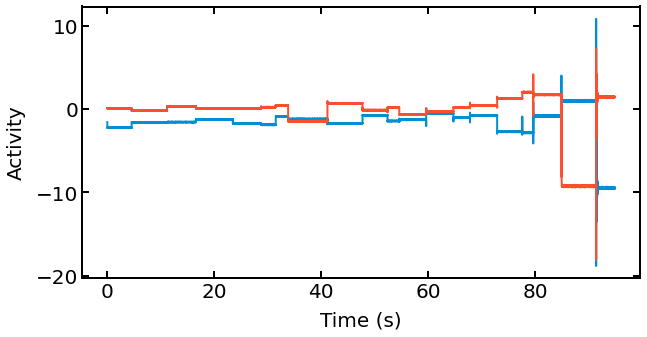

In [215]:
plt.plot(np.arange(pts.shape[0])*dt, pts[:, 0])
plt.plot(np.arange(pts.shape[0])*dt, pts[:, 1])
plt.xlabel('Time (s)')
plt.ylabel('Activity')
plt.show()

# VAR Grid Search

In [216]:
data = pts.copy()

In [217]:
windows = [int(w) if w % 1 == 0 else w for w in np.arange(0.5, 10.1, 0.5)]
# windows = np.hstack([np.arange(0.05, 0.101, 0.01), [0.25, 0.5, 0.75, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]])
# windows = [0.25, 0.5, 0.75, 1, 2, 3, 4, 5]
max_lag = 15
lags = np.arange(1, max_lag + 1)
T_pred = 25
num_window_samples = 10

In [218]:
grid_search_df = []
iterator = tqdm(total = len(windows)*len(lags))
for window in windows:
    stride = window
    min_ind = int(0/stride)
    max_ind = int((data.shape[0]*dt - window - T_pred*dt)/stride)
    possible_inds = np.arange(min_ind, max_ind + 1)
    window_inds = np.random.choice(possible_inds, size=(np.min([num_window_samples, len(possible_inds)])), replace=False)
#     num_windows = int(np.floor((data.shape[0]-window)/stride)+1)
    for p in lags:
#         for i in range(num_windows):
        for i in window_inds:
            start_ind = i*int(stride/dt)
            start_time = i*stride
            end_ind = i*int(stride/dt) + int(window/dt)
            end_time = i*stride + window
            if end_ind + T_pred <= data.shape[0]:
                
                window_data = data[start_ind:end_ind]
                results = compute_VAR_p(window_data, p)
                test_data = data[end_ind - p:end_ind + T_pred]

                train_prediction, train_true_vals = predict_VAR_p(window_data, results['coefs'], results['intercept'])
                train_mse = ((train_prediction - train_true_vals)**2).mean()
                test_prediction, test_true_vals = predict_VAR_p(test_data, results['coefs'], results['intercept'])
#                 print(test_prediction.shape)
                test_mse = ((test_prediction - test_true_vals)**2).mean()
                persistence_baseline = ((data[end_ind:end_ind + T_pred] - data[end_ind - 1:end_ind + T_pred -1])**2).mean()

                # ADD TO DICTIONARY
                results['train_mse'] = train_mse
                results['test_mse'] = test_mse
                results['persistence_baseline'] = persistence_baseline

                # ADD TIMESTAMPS
                results['start_ind'] = start_ind
                results['end_ind'] = end_ind
                results['start_time'] = start_time
                results['end_time'] = end_time

                # ADD PARAMETERS
                results['window'] = window
                results['stride'] = stride
                results['p'] = p
                results['T_pred'] = T_pred
                
                grid_search_df.append(results)
        iterator.update()
iterator.close()
grid_search_df = pd.DataFrame(grid_search_df)

  0%|          | 0/300 [00:00<?, ?it/s]

In [219]:
test_mse_mat = np.zeros((len(windows), len(lags)))
for i, window in enumerate(windows):
    for j, p in enumerate(lags):
        test_mse_mat[i, j] = grid_search_df[np.logical_and(grid_search_df.window == window, grid_search_df.p == p)].test_mse.mean()

In [220]:
def pick_2d_optimum(mat, thresh=0.95):
    true_min = mat.min()
    i_vals, j_vals = np.where(mat*thresh - true_min <= 0)
    selected_i = np.min(i_vals)
    selected_j = np.min(j_vals[i_vals == selected_i])
    selected_i, selected_j

    return selected_i, selected_j
thresh = 1
w_ind, p_ind = pick_2d_optimum(test_mse_mat, thresh)

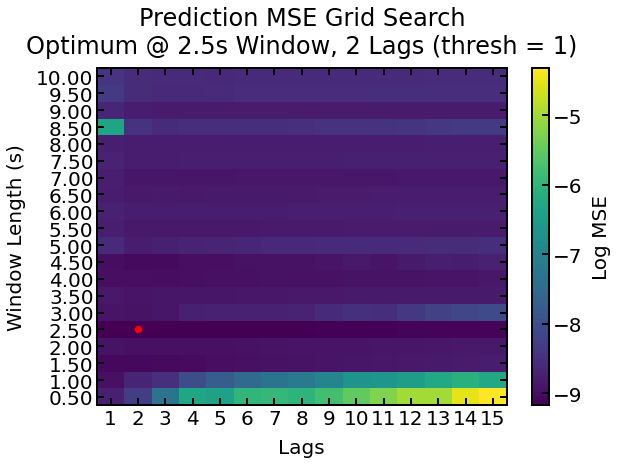

In [221]:
log_test_mse_mat = np.log(test_mse_mat)
plt.style.use('../../sci_style.py')
plt.figure(figsize=(9, 6))
# norm = colors.TwoSlopeNorm(vmin=test_mse_mat.min(), vcenter=test_mse_mat.mean(), vmax=test_mse_mat.max())
# plt.pcolormesh(test_mse_mat, norm=norm)
plt.pcolormesh(log_test_mse_mat)
plt.xticks(np.arange(0, max_lag) + 0.5, [lags[i] for i in np.arange(0, max_lag)])
plt.yticks(np.arange(0, len(windows)) + 0.5, [f"{windows[i]:.2f}" for i in np.arange(0, len(windows))])
plt.xlabel('Lags')
plt.ylabel('Window Length (s)')
cbar = plt.colorbar(label='Log MSE')
# cbar_ticks = [norm.vmin + t*(norm.vcenter-norm.vmin) for t in np.arange(0, 1.1, 0.2)]
# cbar_ticks += [norm.vcenter + t*(norm.vmax-norm.vcenter) for t in np.arange(0, 1.1, 0.2)]
# cbar.set_ticks(cbar_ticks)
plt.scatter([p_ind + 0.5], [w_ind + 0.5], color='red', s=40, label='min')
plt.tight_layout()
plt.title(f"Prediction MSE Grid Search\nOptimum @ {windows[w_ind]}s Window, {lags[p_ind]} Lags (thresh = {thresh})")
plt.show()

# Compute VAR Results

In [223]:
window = windows[w_ind]
p = lags[p_ind]

VAR_results = []
num_windows = int(np.floor((data.shape[0]-int(window/dt))/int(stride/dt)+1))
stride = window
for i in tqdm(range(num_windows)):
    start_ind = i*int(stride/dt)
    start_time = i*stride
    end_ind = i*int(stride/dt) + int(window/dt)
    end_time = i*stride + window
    if end_ind + T_pred <= data.shape[0]:

        window_data = data[start_ind:end_ind]
        results = compute_VAR_p(window_data, p)
        test_data = data[end_ind - p:end_ind + T_pred]

        train_prediction, train_true_vals = predict_VAR_p(window_data, results['coefs'], results['intercept'])
        train_mse = ((train_prediction - train_true_vals)**2).mean()
        test_prediction, test_true_vals = predict_VAR_p(test_data, results['coefs'], results['intercept'])
#                 print(test_prediction.shape)
        test_mse = ((test_prediction - test_true_vals)**2).mean()
        persistence_baseline = ((data[end_ind:end_ind + T_pred] - data[end_ind - 1:end_ind + T_pred -1])**2).mean()

        # ADD TO DICTIONARY
        results['train_mse'] = train_mse
        results['test_mse'] = test_mse
        results['persistence_baseline'] = persistence_baseline

        # ADD TIMESTAMPS
        results['start_ind'] = start_ind
        results['end_ind'] = end_ind
        results['start_time'] = start_time
        results['end_time'] = end_time

        # ADD PARAMETERS
        results['window'] = window
        results['stride'] = stride
        results['p'] = p
        results['T_pred'] = T_pred

        VAR_results.append(results)
VAR_results = pd.DataFrame(VAR_results)

  0%|          | 0/37 [00:00<?, ?it/s]

In [224]:
# VAR_results = grid_search_df[np.logical_and(grid_search_df.window == windows[w_ind], grid_search_df.p == lags[p_ind])]

In [225]:
criticality_inds = np.array([np.abs(np.linalg.eigvals(A_mats[i])) for i in range(len(A_mats))])

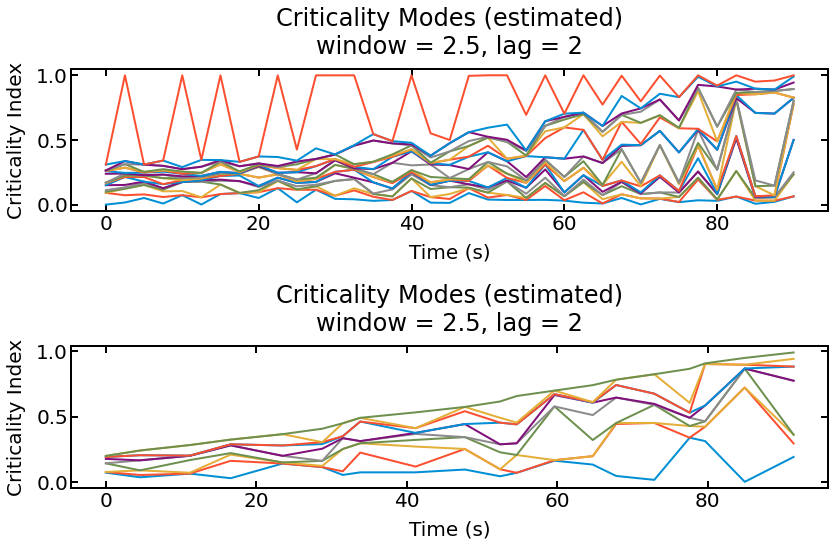

In [226]:
# plot mode criticalities
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
mode_criticalities = np.zeros((len(VAR_results), len(VAR_results.criticality_inds.iloc[0])))
for i, row in VAR_results.iterrows():
    mode_criticalities[i] = np.sort(row.criticality_inds)

for i in range(len(VAR_results.criticality_inds.iloc[0])):
    plt.plot(VAR_results.start_time, mode_criticalities[:, i])
plt.xlabel('Time (s)')
plt.ylabel('Criticality Index')
plt.title(f"Criticality Modes (estimated)\nwindow = {window}, lag = {p}")

plt.subplot(2, 1, 2)
mode_criticalities = np.zeros(criticality_inds.shape)
for i in range(criticality_inds.shape[0]):
    mode_criticalities[i] = np.sort(criticality_inds[i])

for i in range(criticality_inds.shape[1]):
    plt.plot(np.hstack([[0], np.cumsum(window_lengths)[:-1]]), mode_criticalities[:, i])
plt.xlabel('Time (s)')
plt.ylabel('Criticality Index')
plt.title(f"Criticality Modes (estimated)\nwindow = {window}, lag = {p}")
plt.tight_layout()
plt.show()

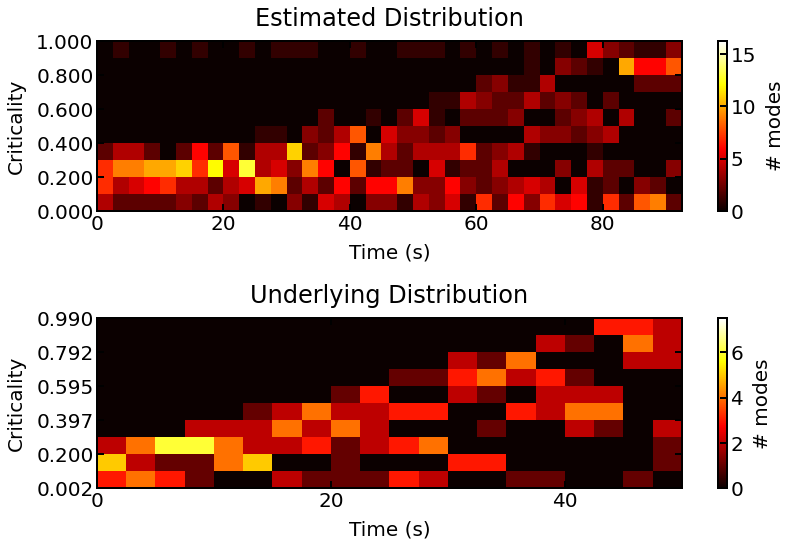

In [227]:
bin_nums = 10
bin_min = np.concatenate(VAR_results.criticality_inds.to_numpy()).min()
bin_max = np.concatenate(VAR_results.criticality_inds.to_numpy()).max()
bins = [(bin_max - bin_min)*i/bin_nums + bin_min for i in range(bin_nums + 1 )]
criticality_prob_dist = np.zeros((VAR_results.criticality_inds.shape[0], bin_nums))
for t in range(VAR_results.criticality_inds.shape[0]):
    criticality_prob_dist[t] = np.histogram(VAR_results.criticality_inds[t], bins=bins)[0]
start_times = np.arange(VAR_results.criticality_inds.shape[0])*stride/60
T_max = VAR_results.criticality_inds.shape[0]*stride
fig = plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
ax = plt.gca()
im = plt.pcolormesh(criticality_prob_dist.T, cmap='hot', vmin=criticality_prob_dist.min(), vmax=criticality_prob_dist.max()*1.25)
ax.set_xticks([int(i/stride) for i in np.arange(0, T_max, 20)], [int(i) for i in np.arange(0, T_max, 20)])
ax.set_yticks(np.arange(0, bin_nums + 1, 2), [f"{b:.3f}" for b in np.array(bins)[np.arange(0, bin_nums + 1, 2)]])
cb = fig.colorbar(im, ax=ax)
cb.set_label(label='# modes')
plt.xlabel("Time (s)")
plt.ylabel("Criticality")
plt.title("Estimated Distribution")
# ------------------
# TRUE VALS
# -------------------
plt.subplot(2, 1, 2)
plt.title("Underlying Distribution")
bin_nums = 10
bin_min = criticality_inds.flatten().min()
bin_max = criticality_inds.flatten().max()
bins = [(bin_max - bin_min)*i/bin_nums + bin_min for i in range(bin_nums + 1 )]
criticality_prob_dist = np.zeros((criticality_inds.shape[0], bin_nums))
for t in range(criticality_inds.shape[0]):
    criticality_prob_dist[t] = np.histogram(criticality_inds[t], bins=bins)[0]
start_times = np.arange(criticality_inds.shape[0])*stride/60
T_max = criticality_inds.shape[0]*stride
ax = plt.gca()
im = plt.pcolormesh(criticality_prob_dist.T, cmap='hot', vmin=criticality_prob_dist.min(), vmax=criticality_prob_dist.max()*1.25)
ax.set_xticks([int(i/stride) for i in np.arange(0, T_max, 20)], [int(i) for i in np.arange(0, T_max, 20)])
ax.set_yticks(np.arange(0, bin_nums + 1, 2), [f"{b:.3f}" for b in np.array(bins)[np.arange(0, bin_nums + 1, 2)]])
cb = fig.colorbar(im, ax=ax)
cb.set_label(label='# modes')
plt.xlabel("Time (s)")
plt.ylabel("Criticality")
plt.tight_layout()
plt.show()